In [261]:
import pandas as pd
import numpy as np
# Importing airquality module
from airquality import AirQuality
import plotly.express as px
from matplotlib import pyplot
from datetime import date

# For investigating timeseries data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

# Global Variables
REFRESH_DATA = False
DATA_QUANTITY = 500
LOCATION_OF_INTEREST = '1067'

In [262]:
# Defining city id's
city1_ids = [ 1067, 1068, 1069, 1502]

In [263]:
combined_df = []
if REFRESH_DATA:
    air_measurements = []
    # Iterating through sensor locations and creating object to store data for each
    for location in city1_ids:
        quality = AirQuality(location)
        quality.pull_data(200)
        print(quality.raw_data.head(10))
        air_measurements.append(quality.raw_data)

    combined_df = pd.concat(air_measurements)
    combined_df.to_csv('./Data/air_polution.csv')
    combined_df.head(10)
else:
    combined_df = pd.read_csv('./Data/air_polution.csv')

In [264]:
combined_df['location'] = combined_df['location'].astype(str)
combined_df = combined_df.drop(columns = ['Unnamed: 0'])

### Timeseries

In [265]:
timeseries_plot = px.line(combined_df, x = 'Data_Converted', y = 'Value', color='location',
                                title = "pm25 polution, Portland Oregon")
timeseries_plot.show()

### Developing Forecast

In [266]:
print(combined_df['location'].drop_duplicates())
test_df = combined_df[combined_df['location'] == '1067']
test_df.head(10)

0      1067
200    1068
400    1069
600    1502
Name: location, dtype: object


,Date,Value,location,parameter,longitude,latitude,Data_Converted
0,2024-07-27T20:00:00+00:00,5.3,1067,pm25,-122.7721,45.768531,2024-07-27 20:00:00+00:00
1,2024-07-27T19:00:00+00:00,4.7,1067,pm25,-122.7721,45.768531,2024-07-27 19:00:00+00:00
2,2024-07-27T18:00:00+00:00,4.4,1067,pm25,-122.7721,45.768531,2024-07-27 18:00:00+00:00
3,2024-07-27T17:00:00+00:00,4.2,1067,pm25,-122.7721,45.768531,2024-07-27 17:00:00+00:00
4,2024-07-27T16:00:00+00:00,4.0,1067,pm25,-122.7721,45.768531,2024-07-27 16:00:00+00:00
5,2024-07-27T15:00:00+00:00,3.8,1067,pm25,-122.7721,45.768531,2024-07-27 15:00:00+00:00
6,2024-07-27T14:00:00+00:00,3.8,1067,pm25,-122.7721,45.768531,2024-07-27 14:00:00+00:00
7,2024-07-27T13:00:00+00:00,3.7,1067,pm25,-122.7721,45.768531,2024-07-27 13:00:00+00:00
8,2024-07-27T12:00:00+00:00,3.7,1067,pm25,-122.7721,45.768531,2024-07-27 12:00:00+00:00
9,2024-07-27T11:00:00+00:00,3.4,1067,pm25,-122.7721,45.768531,2024-07-27 11:00:00+00:00


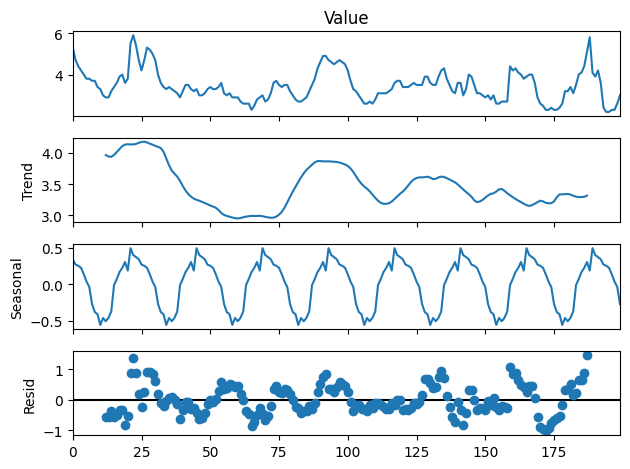

In [267]:
result = seasonal_decompose(combined_df[combined_df['location'] == '1067']['Value'], 
                            model='additive', period=24)
result.plot()
pyplot.show()

### Univariate Timeseries Analysis

Ad Fuller Test:

H0: There's a root unit present in the timeseries(i.e. not stationary)

H1: There's no root unit present in the timeseries(i.e. data is stationary)

If P < critical value(0.05) conclude that H0 is false and data is stationary.


In [268]:
target_location = combined_df['location'].drop_duplicates()[0]
univariate_df = combined_df[combined_df['location'] == target_location]

# Checking if data is stationary
adf_results = adfuller(univariate_df['Value'])

print("Statistic: ", round(adf_results[0],3))
print("P-value: ", round(adf_results[1],6))

Statistic:  -5.136
P-value:  1.2e-05


### Plotting ACF and PACF
1. Moving Average portion of model(q) depends on ACF test
2. Autoregressive portion of model(p) depends on PACF test


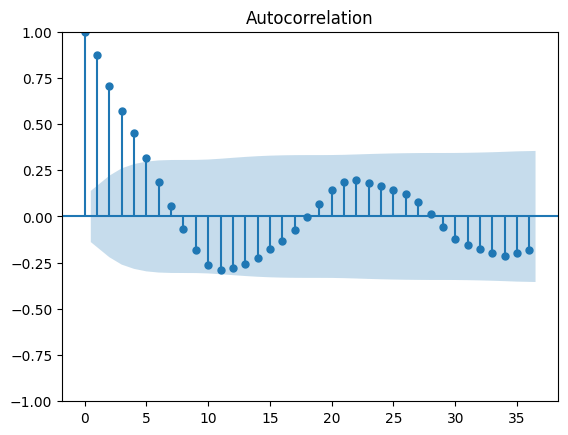

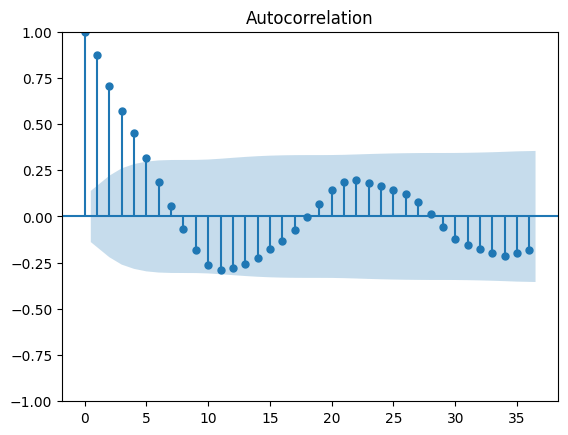

In [269]:
plot_acf(univariate_df['Value'], lags=36)

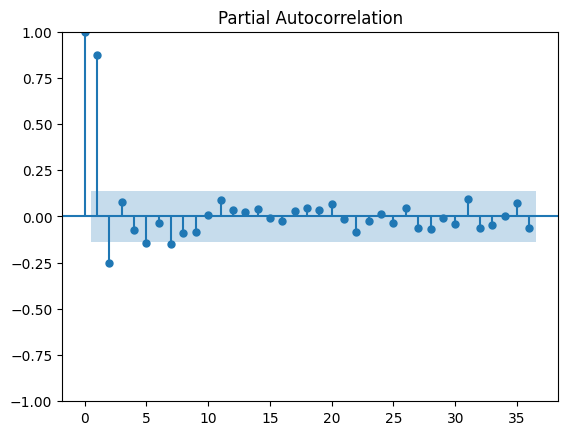

In [270]:
plot_pacf(univariate_df['Value'], lags=36)
pyplot.show()

### Building ARIMA Model

Order is defined as (p,d,q) = (Autoregressive, integration(how many times we difference), Moving Average)

In [271]:
order = (5, 0, 2)
model = ARIMA(univariate_df['Value'], order= order)

In [272]:
univariate_df = univariate_df.sort_values(by = 'Data_Converted')

In [273]:
# split into train and test sets
X = univariate_df['Value'].values
# Train - non 2021 months, Test - 2021 months
size = int(len(X) - 24) 
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [274]:
predictions = []
for month in range(len(test)):
    fitting_df = univariate_df['Value'][:len(train)+month]
    model = ARIMA(fitting_df, order= order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    predictions.append(yhat)


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [275]:
# evaluate forecasts
r2 = r2_score(univariate_df['Value'][-len(predictions):], predictions)
print('Test R2 Score: %.3f' % r2)

Test R2 Score: 0.723


In [276]:
# Melting down comparison dataframe for plotting
actual_df = univariate_df[['Data_Converted', 'Value']]
actual_df['Variable'] = 'Actual'
dates = univariate_df['Data_Converted'][-len(predictions):]
test_dict = {'Data_Converted': dates,
                             'Value': predictions}

predicted_df = pd.DataFrame.from_dict(test_dict)
predicted_df['Variable'] = 'Predicted'
compare_df = pd.concat([actual_df, predicted_df])

C:\Users\seelc\AppData\Local\Temp\ipykernel_26492\3599212786.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [277]:
# Graphing predictions vs actual values
predictions_fig = px.line(compare_df,x = 'Data_Converted', y = 'Value', color = 'Variable', 
                            title = 'Air Polution Forecasted vs Acual ' + 'R2 Score: '+ str(round(r2,2)))
predictions_fig.show()

### Multivariate Model

First we want to measure the correlation of exogenous variables at offset value t with our response variable. To do this we'll create a helper function to offset our data and measure correlation using a pearson correlation coefficient.

In [278]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

Next we need to reshape our data so each of the values of the locations is a separate column.

### Test Method for Reshaping Data + Dealing Different Dates

In [279]:
def reshape_and_clean(combined_df):

    """ Pivots dataframe so each locations particulate value is
    its own column. Uses backfill interpolation to replace null values.

    Parameters
    ----------
    combined_df : dataframe, contains air particulate data for different locations
    Returns
    ----------
    multivariate_df : dataframe, each location having its own column
    """

    test_df = combined_df.sort_values(by = 'Data_Converted')
    locations = combined_df['location'].drop_duplicates().to_list()
    locations.remove(LOCATION_OF_INTEREST)

    multivariate_df = combined_df[combined_df['location'] == LOCATION_OF_INTEREST].rename(columns={'Value':LOCATION_OF_INTEREST})[['Date', LOCATION_OF_INTEREST]]

    for location in locations:
        subset_df = combined_df[combined_df['location'] == location]
        subset_df = subset_df.rename(columns ={'Value':location})
        subset_df = subset_df[[ 'Date', location]]
        
        multivariate_df = multivariate_df.merge(subset_df, how = 'left', on = 'Date')

    # If a value is NAN will use the previous value in that series to fill it
    for location in locations:
        multivariate_df[location] = multivariate_df[location].ffill()
    multivariate_df.head(10)

    return multivariate_df

,Date,1067,1068,1069,1502
0,2024-07-27T20:00:00+00:00,5.3,4.6,5.6,3.5
1,2024-07-27T19:00:00+00:00,4.7,4.5,5.2,3.3
2,2024-07-27T18:00:00+00:00,4.4,4.3,5.2,3.2
3,2024-07-27T17:00:00+00:00,4.2,4.1,4.6,2.9
4,2024-07-27T16:00:00+00:00,4.0,4.2,4.7,2.8
5,2024-07-27T15:00:00+00:00,3.8,4.1,4.7,2.8
6,2024-07-27T14:00:00+00:00,3.8,3.5,5.4,2.7
7,2024-07-27T13:00:00+00:00,3.7,3.4,4.8,2.5
8,2024-07-27T12:00:00+00:00,3.7,3.2,4.8,2.4
9,2024-07-27T11:00:00+00:00,3.4,3.1,5.1,2.4


In [ ]:
multivariate_df = reshape_and_clean(combined_df)
multivariate_df.head(10)

In [280]:
# Creating list of x_vars and dropping date
x_vars = multivariate_df.columns.to_list()[1:]
# Saving response variable
response_var = multivariate_df.columns.to_list()[1]
# Dropping response variable form x_vars
corr_matrix = []
x_vars = x_vars[1:]
lags = range(1,6)
for var in x_vars:
    var_cor = []
    for lag in lags:
        var_cor.append(round(crosscorr(multivariate_df[response_var], multivariate_df[var], lag = lag),2))
    corr_matrix.append(var_cor)

In [281]:
print(lags)
fig = px.imshow(corr_matrix,
                labels=dict(x="Lag", y="Variable", color="Pearson Correlation"),
                x=[i for i in lags],
                y=x_vars,
                text_auto=True,
                title= "Variable Correlation Exogenous variables"
               )
fig.show()

range(1, 6)


In [282]:
multivariate_df

,Date,1067,1068,1069,1502
0,2024-07-27T20:00:00+00:00,5.3,4.6,5.6,3.5
1,2024-07-27T19:00:00+00:00,4.7,4.5,5.2,3.3
2,2024-07-27T18:00:00+00:00,4.4,4.3,5.2,3.2
3,2024-07-27T17:00:00+00:00,4.2,4.1,4.6,2.9
4,2024-07-27T16:00:00+00:00,4.0,4.2,4.7,2.8
...,...,...,...,...,...
195,2024-07-19T08:00:00+00:00,2.2,2.5,3.9,2.2
196,2024-07-19T07:00:00+00:00,2.3,2.5,3.9,1.9
197,2024-07-19T06:00:00+00:00,2.3,2.5,3.9,2.0
198,2024-07-19T05:00:00+00:00,2.6,2.5,3.9,2.5


assembling and standardizing multivariate dataframe

In [283]:
exogenous_vars = ['1069']
dependent = ['1067']
total_vars = exogenous_vars + dependent

multivariate_df = multivariate_df[['Date'] + exogenous_vars + dependent]

# Scaling dependent/independent variables to have same min/max vals
x = multivariate_df[total_vars].values 
min_max_scaler = preprocessing.MinMaxScaler()
multivariate_df_scaled = pd.DataFrame(min_max_scaler.fit_transform(x),
                                                           columns = total_vars)
# Adding back date
multivariate_df_scaled['Date'] = multivariate_df['Date']
multivariate_df_scaled.head(10)

,1069,1067,Date
0,0.279570,0.837838,2024-07-27T20:00:00+00:00
1,0.236559,0.675676,2024-07-27T19:00:00+00:00
2,0.236559,0.594595,2024-07-27T18:00:00+00:00
3,0.172043,0.540541,2024-07-27T17:00:00+00:00
4,0.182796,0.486486,2024-07-27T16:00:00+00:00
5,0.182796,0.432432,2024-07-27T15:00:00+00:00
6,0.258065,0.432432,2024-07-27T14:00:00+00:00
7,0.193548,0.405405,2024-07-27T13:00:00+00:00
8,0.193548,0.405405,2024-07-27T12:00:00+00:00
9,0.225806,0.324324,2024-07-27T11:00:00+00:00


Fitting multivariate model

In [284]:
# Defining train period
train_count= 12
# Selecting all data except last 12 points
target_train = multivariate_df_scaled[dependent[0]][:-train_count]
exog_train = multivariate_df_scaled[exogenous_vars[0]][:-train_count]


best_model = SARIMAX(target_train, exog_train, order=(1,0,2), 
 seasonal_order=(3,0,1,12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

